In [1]:
import pandas as pd
import numpy as np
import datetime

In [2]:
from sklearn.preprocessing import LabelEncoder

In [4]:
from matplotlib import pyplot as plt
%matplotlib inline

In [5]:
def generate_date_str(month, day, year):
    return '20{}-{:02d}-{:02d}'.format(int(year), int(month), int(day))

In [6]:
def coalesce(x):
    if x:
        return x
    else:
        return []

In [7]:
gov_events = pd.read_excel('../20200323-acaps-covid-19-goverment-measures-dataset-v1.xlsx', sheet_name=1)
gov_events = gov_events[['COUNTRY', 'CATEGORY', 'DATE_IMPLEMENTED']]
gov_events.columns = ['country', 'events', 'date']
gov_events['date'] = gov_events['date'].astype(str)

In [8]:
label_encoder_model = LabelEncoder().fit(gov_events['events'].unique())
gov_events['events'] = label_encoder_model.fit_transform(gov_events['events']).astype(str)

In [9]:
first_case_ix = str(int(gov_events['events'].max()) + 1)

In [10]:
corona_time_series = pd.read_csv('../time_series_covid19_confirmed_global.csv')
corona_time_series = corona_time_series.rename({'Province/State': 'province', 'Country/Region': 'country'}, axis=1).drop(['Lat', 'Long'], axis=1)
corona_date_columns = [generate_date_str(*_.split('/')) for _ in corona_time_series.columns[2:]]
corona_time_series.columns = list(corona_time_series.columns[:2]) + corona_date_columns

In [11]:
time_series_df = pd.melt(corona_time_series, id_vars=['country', 'province'], value_vars=corona_time_series.columns[2:])
time_series_df.columns = ['country', 'province', 'date', 'cases']
time_series_df['province'] = time_series_df['province'].fillna('')

other_series = time_series_df.loc[~(time_series_df['country'] == 'China')]
china_series = time_series_df.loc[(time_series_df['country'] == 'China') & (time_series_df['province'] == 'Hubei')].groupby(['country', 'province', 'date'])['cases'].max().reset_index()
other_series = other_series.groupby(['country', 'date'])['cases'].min().reset_index()
time_series_df = pd.concat([other_series, china_series], axis=0).drop('province', axis=1)

In [12]:
first_case_df = time_series_df.loc[time_series_df['cases'] > 0].groupby(['country'])['date'].min().reset_index(name='date')
first_case_df['events'] = [[first_case_ix] for _ in range(len(first_case_df))]

In [13]:
events_over_time_df = gov_events.groupby(['country', 'date'])['events'].apply(lambda x: set(x)).apply(list).reset_index(name='events')
events_over_time_df = events_over_time_df.merge(first_case_df, on=['country', 'date'], how='left')

In [14]:
events_over_time_df['events'] = events_over_time_df.iloc[:,2:].fillna('').apply(lambda x: x[0] + coalesce(x[1]), axis=1).apply(','.join)
events_over_time_df = events_over_time_df.drop(['events_x', 'events_y'], axis=1)

0          2
1        6,3
2        2,8
3      6,7,3
4          7
       ...  
846      2,3
847        3
848        3
849        3
850        3
Name: events, Length: 851, dtype: object

In [15]:
result = time_series_df.merge(events_over_time_df, on=['country', 'date'], how='left')
result['events'] = result['events'].fillna('')

In [ ]:
result.to_csv('../cases_events.csv', index=False)

In [76]:
chn_ts = result.loc[result['country'] == 'China']
chn_events = chn_ts.loc[chn_ts['events'] != '']

Text(0.5, 1.0, 'China measurements')

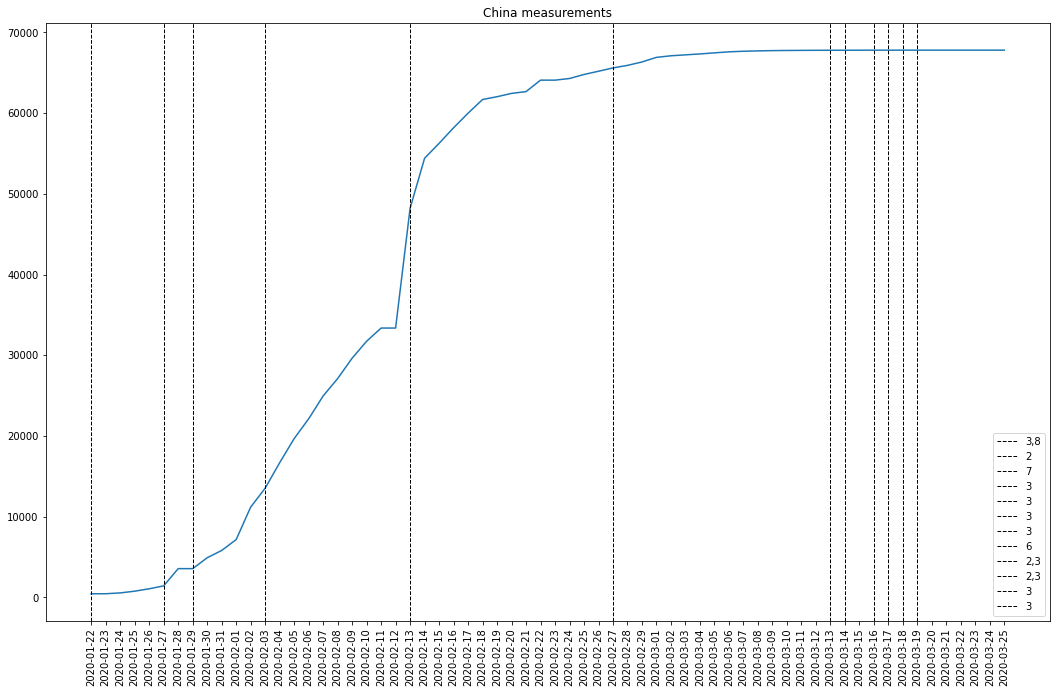

In [89]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True,figsize=(18, 11))
axes.plot(chn_ts['date'], chn_ts['cases'])


plt.xticks(rotation=90)

ymin, ymax = axes.get_ylim()

for (value, events) in chn_ts.loc[chn_ts['events'] != ''][['date', 'events']].values:
    plt.axvline(x=value, color='k', linewidth=1.0, linestyle='--', label=events) 
    
plt.legend()
plt.title('China measurements')

In [85]:
italy_ts = result.loc[result['country'] == 'Italy']

In [102]:
def generate_country_cases_plot(ts_df, country_name):
    
    ts_df = ts_df.loc[ts_df['country'] == country_name]
    
    fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True,figsize=(18, 11))
    axes.plot(ts_df['date'], ts_df['cases'])


    plt.xticks(rotation=90)

    ymin, ymax = axes.get_ylim()

    for (value, events) in ts_df.loc[ts_df['events'] != ''][['date', 'events']].values:
        plt.axvline(x=value, color=np.random.rand(3,), linewidth=1.0, linestyle='--', label=events) 

    plt.title('{} measurements'.format(country_name))
    plt.xlabel('Date')
    plt.ylabel('Cases')

    plt.legend()
    
    plt.savefig('{}_cases_plot.png'.format(country_name))


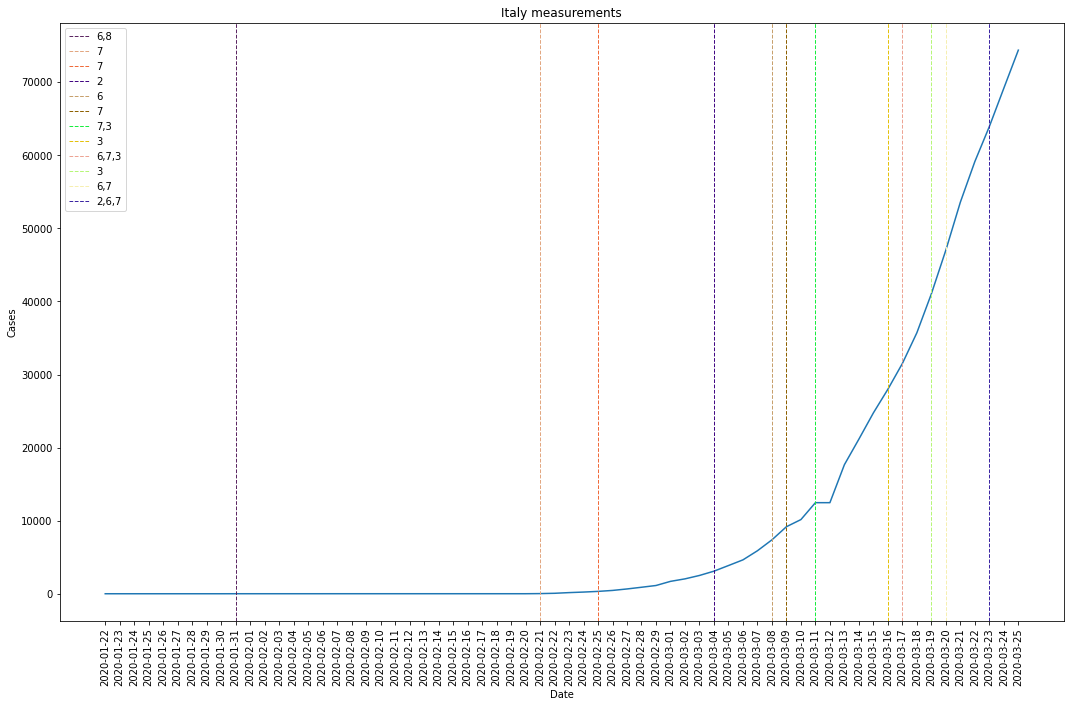

In [113]:
generate_country_cases_plot(result, 'Italy')

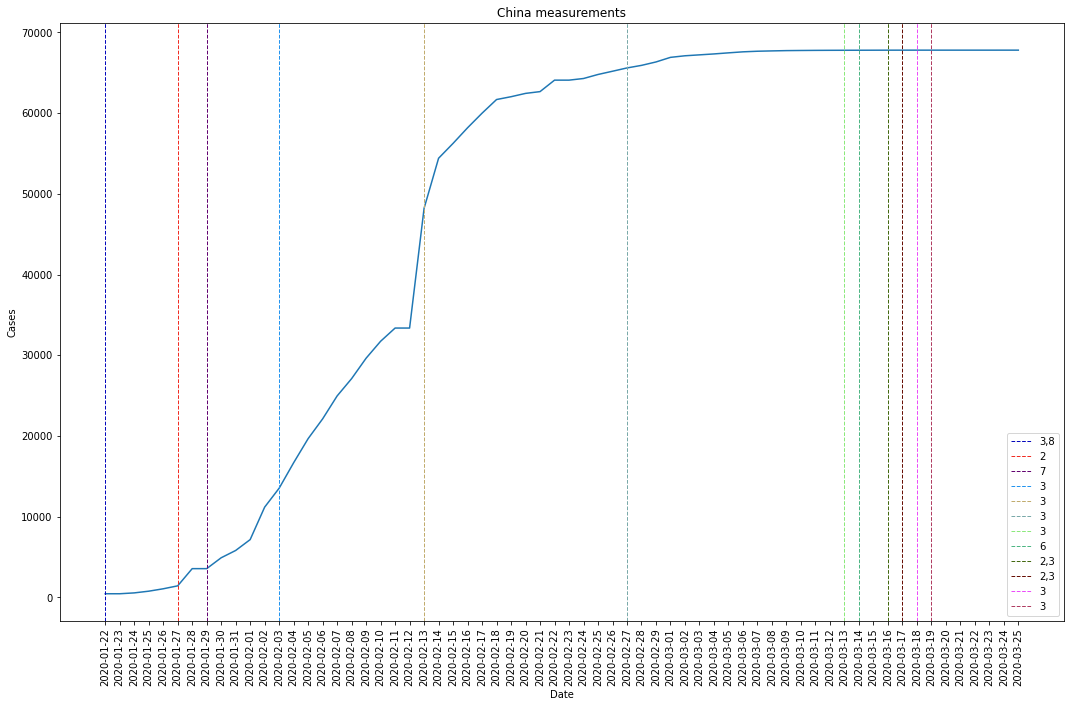

In [104]:
generate_country_cases_plot(result, 'China')

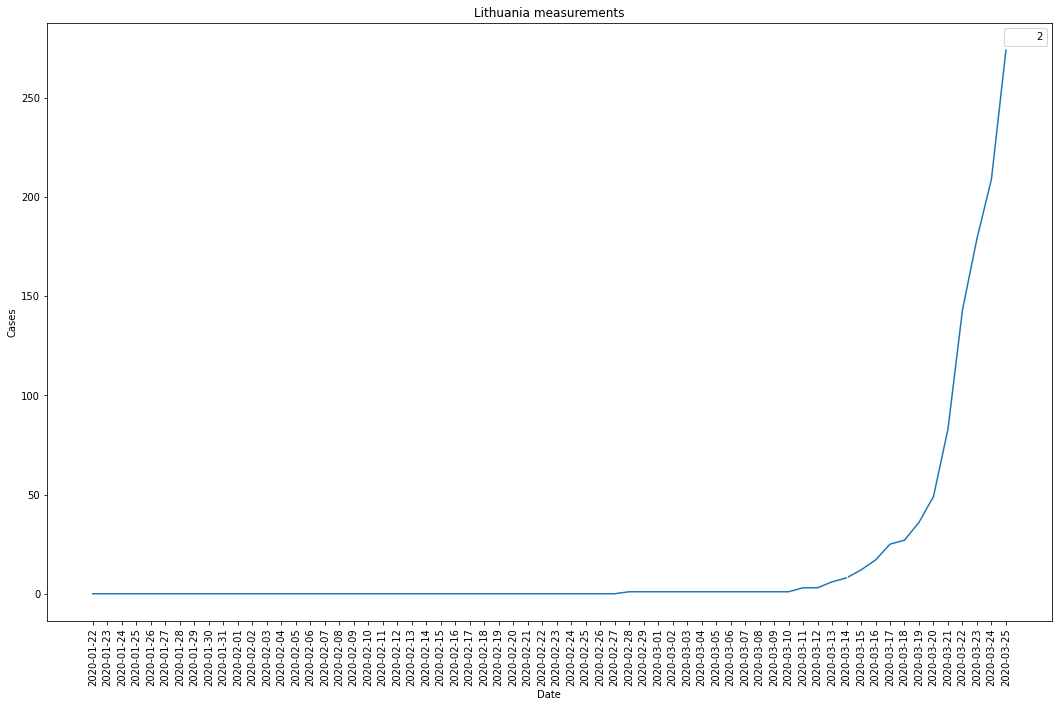

In [105]:
generate_country_cases_plot(result, 'Lithuania')